<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 87.1MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


In [4]:
import re
def process_text(sentence):
    # sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    # sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    # sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    # sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   !!  bład bo usuwa też   znaki w środku wyrazu np I'd -> Id,  I'm -> Im  i przesto nie pozbywamy się stopwordów ALE spacy to wykrywa i dzieli na pełną forma i would  i am . wiec może zostac 
    # sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    # # poniższe usuwanie spacji bo toniezacja w spacy nie radzi sobie z nimi ! (jaja!)
    # sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    # sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    # sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

In [6]:
from sklearn.preprocessing import LabelEncoder
# from keras.wrappers.scikit_learn import KerasClassifier 
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train["X"] = data_set_train["clean_text"]
data_set_train[["clean_text","X","label","labelencoder"]].head(5)

,clean_text,X,label,labelencoder
0,find a cinema nearest for films,find a cinema nearest for films,SearchScreeningEvent,6
1,Give the current series two stars.,Give the current series two stars.,RateBook,4
2,find The Good Girl at a movie house\n,find The Good Girl at a movie house\n,SearchScreeningEvent,6
3,Please make reservations for three at a kosher...,Please make reservations for three at a kosher...,BookRestaurant,1
4,what is the forecast for here one second from now,what is the forecast for here one second from now,GetWeather,2


In [7]:
X = data_set_train["X"]
y = dummy_y

In [8]:
X.shape, y.shape

((13784,), (13784, 7))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

In [11]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  # jaki jest domyślny embending ???? czy można wynik emedingu zobaczyć ? 
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            1004500   
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 1,009,407
Trainable params: 1,009,407
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 3s 16ms/step - loss: 1.5813 - accuracy: 0.6787 - val_loss: 0.4151 - val_accuracy: 0.9365
Epoch 2/20
138/138 [==============================] - 2s 13ms/step - loss: 0.3019 - accuracy: 0.9485 - val_loss: 0.1736 - val_accuracy: 0.9578
Epoch 3/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1219 - accuracy: 0.9792 - val_loss: 0.1213 - val_accuracy: 0.9701
Epoch 4/20
138/138 [==============================] - 2s 13ms/step - loss: 0.0703 - accuracy: 0.9882 - val_loss: 0.0996 - val_accuracy: 0.9737
Epoch 5/20
138/138 [==============================] - 2s 13ms/step - loss: 0.0447 - accuracy: 0.9938 - val_loss: 0.0887 - val_accuracy: 0.9751
Epoch 6/20
138/138 [==============================] - 2s 13ms/step - loss: 0.0330 - accuracy: 0.9947 - val_loss: 0.0827 - val_accuracy: 0.9764
Epoch 7/20
138/138 [==============================] - 2s 14ms/step - loss: 0.0236 - accuracy: 0.9966 - val_loss: 0.0788 - val_accuracy: 0.9773

In [16]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

In [17]:
# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[  17,   45,   53, ...,   47,    7,    1],
       [ 254,  190,   24, ..., 1742,    4,  783],
       [  17,   10,    1, ...,   39,    5,   51],
       ...,
       [  31,    1,   92, ...,   41,    0,    0],
       [  17,   10,    1, ...,   39,    5, 2890],
       [   9,   48,    2, ...,    5,   75,    7]], dtype=int32)

In [18]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [19]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [20]:
import numpy as np

In [21]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val

array([6, 3, 2, 0, 6, 6, 5, 0, 0, 4, 5, 4, 6, 3, 6, 2, 1, 2, 2, 2, 1, 3,
       0, 1, 3, 4, 0, 4, 0, 3, 1, 5, 5, 5, 4, 5, 1, 2, 1, 4, 5, 0, 2, 5,
       6, 0, 2, 3, 0, 3, 6, 4, 5, 2, 4, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 1,
       6, 6, 0, 5, 2, 4, 1, 0, 0, 1, 3, 3, 2, 3, 6, 4, 2, 2, 3, 5, 0, 4,
       2, 1, 1, 3, 2, 0, 6, 1, 6, 5, 1, 0, 4, 1, 4, 0, 0, 2, 1, 0, 3, 5,
       0, 5, 1, 5, 1, 6, 0, 1, 0, 1, 6, 2, 1, 5, 2, 6, 2, 5, 1, 4, 3, 1,
       3, 1, 4, 2, 0, 1, 6, 3, 1, 2, 1, 0, 3, 6, 4, 2, 3, 5, 2, 1, 5, 6,
       2, 4, 6, 0, 2, 6, 3, 4, 1, 4, 1, 5, 4, 6, 2, 4, 2, 2, 2, 3, 6, 1,
       6, 4, 0, 5, 1, 4, 2, 1, 1, 3, 5, 4, 3, 1, 2, 6, 3, 3, 5, 3, 5, 2,
       0, 0, 5, 6, 5, 2, 2, 0, 1, 0, 0, 6, 4, 1, 3, 4, 1, 1, 2, 0, 4, 1,
       4, 1, 5, 3, 5, 2, 0, 1, 0, 1, 2, 1, 2, 2, 6, 0, 1, 5, 0, 2, 2, 2,
       4, 0, 6, 0, 6, 4, 1, 0, 3, 6, 0, 5, 2, 4, 5, 4, 4, 6, 4, 5, 6, 5,
       5, 1, 1, 4, 3, 5, 2, 4, 0, 0, 0, 4, 5, 5, 1, 5, 6, 3, 0, 0, 5, 4,
       2, 4, 5, 0, 1, 2, 5, 3, 0, 1, 4, 2, 2, 0, 1,

In [22]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [23]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [24]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.97
F1_score: 0.97
                      precision    recall  f1-score   support

       AddToPlaylist       0.97      1.00      0.99       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       0.99      0.97      0.98       100
           PlayMusic       1.00      0.96      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.88      1.00      0.94       100
SearchScreeningEvent       0.99      0.88      0.93       100

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

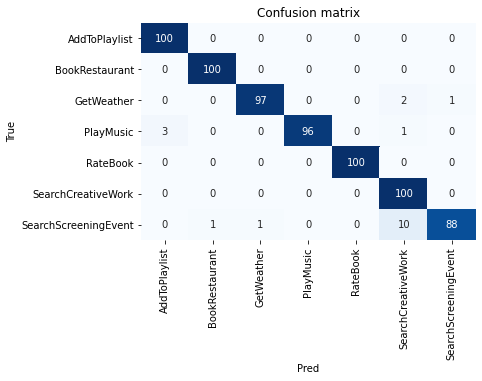

In [25]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [29]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[6, 330, 343, 484, 519, 557, 611, 615, 648, 689]


In [30]:
# Tekst komendy użytkownika

for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['clean_text'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
I want to see While the Sun Shines at the closest movie house.
Oczyszczona komenda:
I want to see While the Sun Shines at the closest movie house.
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I need to find the movie theatre showing The Crooked Web closest to me
Oczyszczona komenda:
I need to find the movie theatre showing The Crooked Web closest to me
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Married to the Enemy 2 at a cinema.
Oczyszczona komenda:
I want to see Married to the Enemy 2 at a cinema.
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see The Portrait of a Lady at the nearest cinema.
Oczyszczona komenda:
I want to see The Portrait of a Lady at the nearest cinema.
True category: Search